In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

attention_dir = os.path.join(project_dir, 'modules/AttentionMap')
if attention_dir not in sys.path:
    sys.path.append(attention_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir) 

import numpy as np
import torch, config
from torch import nn
import os

# Dataset

In [2]:
from derma.dataset import Derma, get_samples_weight
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, Resize

transform = Compose([
        Resize(128),
        RandomHorizontalFlip(), 
        RandomVerticalFlip(),
        RandomRotation(25),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = Compose([
        Resize(128),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dataset = Derma(config.DATASET_DIR, transform=transform)
val_dataset = Derma(config.DATASET_DIR, transform=val_transform)

from torch.utils.data import DataLoader, random_split
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
val_set.dataset = val_dataset # Buscar una forma más elegante de hacerlo

# train_sampler, _ = get_samples_weight(train_set)
# train_loader = DataLoader(train_set, batch_size=64, shuffle=False, sampler=train_sampler)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# val_sampler, _ = get_samples_weight(val_set)
# val_loader = DataLoader(val_set, batch_size=512, shuffle=False, sampler=val_sampler)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

# Model

In [4]:
from derma.architecture import InvertedResidual
from torchvision.models import MobileNetV2

inverted_residual_setting = [
        # t, c, n, s
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]

model = MobileNetV2(num_classes=2, inverted_residual_setting=inverted_residual_setting, block=InvertedResidual)

# Loading pretrained layers
# model.features.load_state_dict(torch.load(os.path.join(config.RESULT_DIR, 'weights/encoder/cifar/encoder.pth')))

# Train

In [4]:
from derma.utils import train
from torch.utils.tensorboard import SummaryWriter

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
tb_writer = SummaryWriter(log_dir=os.path.join(config.RESULT_DIR, 'log/classification/derma'))
criterion = torch.nn.CrossEntropyLoss()

train(model, [train_loader, val_loader], optimizer, criterion, 25, tb_writer)

100%|██████████| 25/25 [11:58<00:00, 28.74s/epoch, acc=0.8750, tls=0.4012]


0.3514110743999481

In [5]:
save_dir = os.path.join(config.RESULT_DIR, 'weights/classifier/derma')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))

# Testing GradCam

In [5]:
model.load_state_dict(torch.load(os.path.join(config.RESULT_DIR, 'weights/classifier/derma/model.pth')))

<All keys matched successfully>

In [6]:
from captum.attr import GuidedGradCam, LayerGradCam, LayerAttribution

model.eval()
model.cpu()

inputs, targets = next(iter(val_loader))
inputs = inputs[:8]
inputs.requires_grad = True

guided_gc = GuidedGradCam(model, model.features[-1][0])
# guided_gc = LayerGradCam(model, model.features[-5].conv)
guided_gc.relu_attributions = False

In [7]:
attribution = guided_gc.attribute(inputs, 1)

/home/abian/Workspace/Anaconda/Miniconda/envs/HySpecLab/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


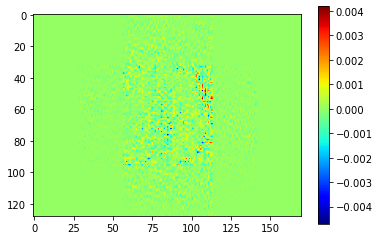

In [8]:
from matplotlib import pyplot as plt 
upsampled_attr = LayerAttribution.interpolate(attribution, (128, 170))
plt.imshow(upsampled_attr[0,2].detach(), cmap='jet')
plt.colorbar()

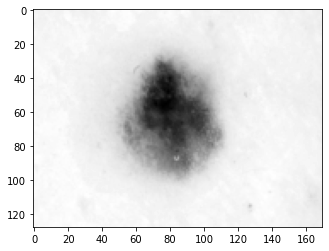

In [9]:
plt.imshow(inputs[0,0].detach(), cmap='gray')

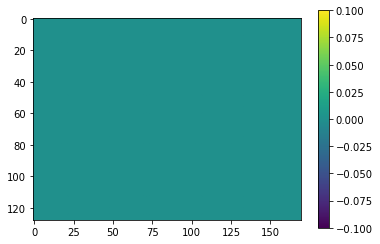

In [10]:
data = attribution.abs().sum(axis=1)
test = np.uint8(255 * data[4].detach())
plt.imshow(data[2].detach())
plt.colorbar()

# Visualization KDE

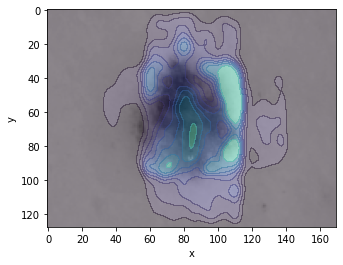

In [23]:
import pandas as pd
import seaborn as sns


data = upsampled_attr.abs().sum(axis=1)
test = data[0].detach().numpy()
# test = torch.relu(upsampled_attr[0, 0].detach()).numpy()
# test = upsampled_attr[0, 0].detach().abs().numpy()
x, y = np.meshgrid(np.arange(test.shape[1]), np.arange(test.shape[0]))

df = pd.DataFrame({'x': x.ravel(), 'y': y.ravel(), 'z': test.ravel()})
sns.kdeplot(x=df['x'], y=df['y'], weights=df['z'], cmap='mako', shade=True, bw_adjust=0.5, alpha=0.5, thresh=0)
plt.imshow(inputs[0, 0].detach().numpy(), cmap='gray')

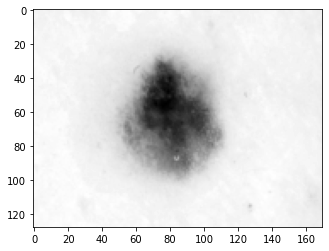

In [24]:
plt.imshow(inputs[0, 0].detach().numpy(), cmap='gray')

In [18]:
targets

tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
test.T.shape

In [ ]:
x.shape


In [ ]:
inputs[1, 0].detach().numpy().shape

In [ ]:
print(test.ravel().shape)
print(x.ravel().shape)
print(y.ravel().shape)

In [ ]:
from scipy.stats.kde import gaussian_kde

test = upsampled_attr[1, 0].detach().numpy()
k = gaussian_kde(test.flatten())

x, y = np.indices(test.shape)
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

c = ax.pcolormesh(y, x, test, cmap='jet')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
y

In [ ]:
_x, _y = np.meshgrid(np.arange(128), np.arange(128))

In [ ]:
_y

In [ ]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel="gaussian")
kde.fit(test)
sco = kde.score_samples(test)

#plot result
plt.imshow(sco, cmap='jet')
plt.colorbar()




In [ ]:
from sklearn import datasets
import pandas as pd
import seaborn as sns

iris = datasets.load_iris()
  
iris_df = pd.DataFrame(iris.data, columns=['Sepal_Length', 'Sepal_Width', 'Patal_Length', 'Petal_Width'])
iris_df['Target'] = iris.target
  
iris_df['Target'].replace([0], 'Iris_Setosa', inplace=True)
iris_df['Target'].replace([1], 'Iris_Vercicolor', inplace=True)
iris_df['Target'].replace([2], 'Iris_Virginica', inplace=True)

In [ ]:
iris_df

In [ ]:
iris_df['Sepal_Length']

In [ ]:
# Setting up the samples
iris_setosa = iris_df.query("Target=='Iris_Setosa'")
iris_virginica = iris_df.query("Target=='Iris_Virginica'")
  
# Plotting the KDE Plot
sns.kdeplot(iris_setosa['Sepal_Length'], 
            iris_setosa['Sepal_Width'],
            color='r', shade=True, Label='Iris_Setosa',
            cmap="Reds", thresh=0.05)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
X, Y = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 2*np.pi, 150),)
h = np.sin(Y)
Y *= np.linspace(.5, 1, 100)

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(X, Y, h)

In [ ]:
X

In [ ]:
x

In [ ]:
y

In [ ]:
from matplotlib import pyplot as plt 
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.imshow(inputs[0, 0].detach().numpy())
    else:
        plt.imshow(attribution[0,i-1].detach().numpy())

plt.show()

In [ ]:
from matplotlib import pyplot as plt 
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.imshow(inputs[i, 0].detach().numpy())
    else:
        plt.imshow(attribution[0,i-1].detach().numpy())

plt.show()

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

In [ ]:
model.eval()
model.cpu()
guided_gc = GuidedGradCam(model, model.layer4[-1].conv3)
inputs, targets = next(iter(val_loader))
inputs = inputs[:4]
inputs.requires_grad = True

In [ ]:
attribution = guided_gc.attribute(inputs, 1)
print(attribution.shape)

In [ ]:
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
model


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


# image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
# img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = np.array(Image.open('Puppies_(4984818141).jpg'))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

In [ ]:
model.train()
cam = EigenCAM(model, target_layers, use_cuda=True)
grayscale_cam = cam(torch.rand((1,3,128,128), requires_grad=False))[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)